In [142]:
import numpy as np
import pandas as pd
import pickle
import os
import re
from string import punctuation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [143]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"op", "", text)
    text = re.sub(r"\n\n", " \n\n", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    
    return text

In [144]:
with open('poems.txt',  encoding='utf8') as f:
    poems = f.readlines()
    poems = ''.join(str(e) for e in poems)
    poems = clean_text(poems)

In [145]:
vocab = poems.split(' ')

In [146]:
word2int = {w: i for i, w in enumerate(vocab)}
int2word = {i: w for i, w in enumerate(vocab)}

In [147]:
word2int

{'she': 21528,
 'could': 20146,
 'not': 21741,
 'help': 21247,
 'but': 21231,
 'sting': 5,
 'my': 21736,
 'finger': 15602,
 '\n\nclinging': 8,
 'a': 21758,
 'moment': 20559,
 'before': 12876,
 'i': 21739,
 'flung': 13,
 'her': 20508,
 '\n\nto': 20675,
 'the': 21710,
 'ground': 19805,
 'gold': 9656,
 'is': 21447,
 'true': 17826,
 'trick': 5387,
 '\n\nevening': 11609,
 'light': 19144,
 'plays': 10769,
 'on': 21654,
 'roses': 4753,
 '\n\nshe': 20183,
 'curls': 32,
 'into': 20512,
 'herself': 8110,
 'stinger': 35,
 'twitching': 36,
 '\n\ngilt': 37,
 'wings': 20539,
 'folded': 15137,
 'whole': 21055,
 'life': 20493,
 'just': 21652,
 'few': 12371,
 'weeks': 21079,
 '\n\nand': 21733,
 'pain': 19393,
 'subsided': 50,
 'in': 21709,
 '\n\nin': 20392,
 'cold': 19832,
 'hardly': 236,
 'had': 19999,
 'wits': 61,
 'to': 21745,
 'buzz': 63,
 '\n\nno': 20254,
 'warning': 65,
 'from': 20673,
 'either': 67,
 'of': 21716,
 'us': 20608,
 'sleeping': 13657,
 'richness': 74,
 'those': 20533,
 'petals': 1463

In [148]:
pickle.dump(word2int, open('word2int.pickle', 'wb'))
pickle.dump(int2word, open('int2word.pickle', 'wb'))

In [149]:
encoded_text = np.array([word2int[w] for w in vocab])

In [150]:
word_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)

In [151]:
for word in word_dataset.take(10):
    print(word.numpy(), int2word[word.numpy()])

21528 she
20146 could
21741 not
21247 help
21231 but
5 sting
21736 my
15602 finger
8 

clinging
21758 a


In [152]:
sequence_length = 10
BATCH_SIZE = 32
EPOCHS = 30

In [153]:
sequences = word_dataset.batch(2*sequence_length + 1, drop_remainder = True)

In [154]:
for sequence in sequences.take(1):
    print(' '.join([int2word[i] for i in sequence.numpy()]))

she could not help but sting my finger 

clinging a moment before i flung her 

to the ground her gold is


In [155]:
def split_sample(sample):
    ds = tf.data.Dataset.from_tensors((sample[:sequence_length], sample[sequence_length]))
    for i in range(1, (len(sample)-1) // 2):
        input_ = sample[i: i+sequence_length]
        target = sample[i+sequence_length]
        other_ds = tf.data.Dataset.from_tensors((input_, target))
        ds = ds.concatenate(other_ds)
    return ds

In [156]:
dataset = sequences.flat_map(split_sample)

In [157]:
def one_hot_samples(input_, target):
    return tf.one_hot(input_, len(vocab)), tf.one_hot(target, len(vocab))

In [158]:
dataset = dataset.map(one_hot_samples)

In [159]:
for element in dataset.take(1):
    print('Input:', ' '.join([int2word[np.argmax(word_vector)] for word_vector in element[0].numpy()]))
    print('Target:', int2word[np.argmax(element[1].numpy())])
    print('Input shape:', element[0].shape)
    print('Target shape:', element[1].shape)
    print('='*10, '\n')

Input: she could not help but sting my finger 

clinging a
Target: moment
Input shape: (10, 21762)
Target shape: (21762,)



In [160]:
ds = dataset.repeat().shuffle(1024).batch(BATCH_SIZE, drop_remainder = True)

In [161]:
model = Sequential([LSTM(256, input_shape = (sequence_length, len(vocab)), return_sequences = True),
                   Dropout(0.3),
                   LSTM(256),
                   Dense(len(vocab), activation = 'softmax'),
                   ])

In [162]:
model_weights_path = 'model_weights.h5'
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 256)           22547456  
                                                                 
 dropout_6 (Dropout)         (None, 10, 256)           0         
                                                                 
 lstm_13 (LSTM)              (None, 256)               525312    
                                                                 
 dense_6 (Dense)             (None, 21762)             5592834   
                                                                 
Total params: 28,665,602
Trainable params: 28,665,602
Non-trainable params: 0
_________________________________________________________________


In [163]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [164]:
model.fit(ds, steps_per_epoch = (len(encoded_text) - sequence_length) // BATCH_SIZE, epochs = EPOCHS)
model.save(model_weights_path)

Epoch 1/30
679/679 [==============================] - 64s 89ms/step - loss: 7.0259 - accuracy: 0.1137
Epoch 2/30
679/679 [==============================] - 60s 89ms/step - loss: 6.4637 - accuracy: 0.1105
Epoch 3/30
679/679 [==============================] - 60s 88ms/step - loss: 6.3359 - accuracy: 0.1196
Epoch 4/30
679/679 [==============================] - 60s 89ms/step - loss: 5.8458 - accuracy: 0.1627
Epoch 5/30
679/679 [==============================] - 60s 88ms/step - loss: 5.6184 - accuracy: 0.1596
Epoch 6/30
679/679 [==============================] - 60s 88ms/step - loss: 5.3153 - accuracy: 0.1621
Epoch 7/30
679/679 [==============================] - 60s 88ms/step - loss: 4.9165 - accuracy: 0.1740
Epoch 8/30
679/679 [==============================] - 60s 89ms/step - loss: 4.4449 - accuracy: 0.2014
Epoch 9/30
679/679 [==============================] - 60s 89ms/step - loss: 4.0339 - accuracy: 0.2315
Epoch 10/30
679/679 [==============================] - 60s 89ms/step - loss: 3.598

In [165]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy'])


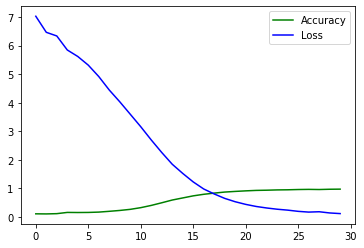

In [166]:
import matplotlib.pyplot as plt
accuracy = model.history.history['accuracy']
loss = model.history.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'g')
plt.plot(epochs, loss, 'b')
plt.legend(['Accuracy','Loss'])
plt.show()